Final energy per qubit = -1.597897950990695


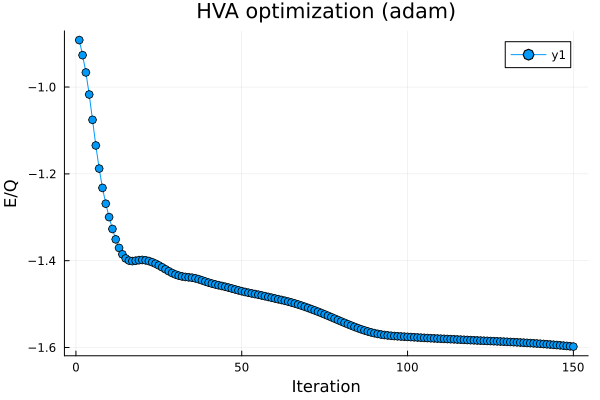

([0.6673242761332735, 0.010893162342014621, 0.5876979311191742, 0.04392340250700096, 0.16447116242104848, -0.4406435258353158, 0.6771374018862923, -0.1110959416654886, 0.7248311423416557, -0.03826948718009342  …  -0.41255739357296406, 0.20965839757416949, -0.044332294647364635, 0.570164372689085, 0.6681957336092641, 0.3172421033303889, -0.7172516159356527, 0.08804317340069413, -0.1134734749277064, 0.951949019993723], [-0.891719241375945, -0.9264813709931873, -0.9662866549846462, -1.0171078615239824, -1.0755067979300288, -1.1345359728528182, -1.1877871638765725, -1.2322723134642057, -1.2687099763472571, -1.2995832191076002  …  -1.5919066075502424, -1.5924797079887336, -1.5930755139924162, -1.5936943413674596, -1.5943364006316885, -1.595001843059063, -1.5956907707923424, -1.5964032065037885, -1.5971390385263666, -1.597897950990695])

In [10]:
using PauliPropagation
using ReverseDiff
using ReverseDiff: GradientTape, compile, gradient!
using Distributions: Uniform
using Plots
using NLopt
using Random

# ──────────────────────────────────────────────────────────────
# 1. Heisenberg Hamiltonian
# ──────────────────────────────────────────────────────────────
function heisenberg_1d_obc(nq::Int; topology=nothing)
    if isnothing(topology)
        topology = bricklayertopology(nq; periodic=false)
    end
    H = PauliSum(nq)
    for pair in topology
        add!(H, [:X, :X], collect(pair), 1.0)
        add!(H, [:Y, :Y], collect(pair), 1.0)
        add!(H, [:Z, :Z], collect(pair), 1.0)
    end
    return H
end

# ──────────────────────────────────────────────────────────────
# 2. Néel state overlap (same as student)
# ──────────────────────────────────────────────────────────────
function neel_bits(nq::Int; up_on_odd::Bool=true)
    if up_on_odd
        return collect(2:2:nq)
    else
        return collect(1:2:nq)
    end
end

function overlapwithneel(operator, nq::Int; up_on_odd::Bool=true)
    nb = neel_bits(nq; up_on_odd=up_on_odd)
    return overlapwithcomputational(operator, nb)
end

# ──────────────────────────────────────────────────────────────
# 3. HVA circuit construction
# ──────────────────────────────────────────────────────────────
"""
    build_HVA_circuit(nq, p)

Constructs a Hamiltonian Variational Ansatz circuit:
U(θ) = ∏ₗ exp(-i θₗ₁ XX) exp(-i θₗ₂ YY) exp(-i θₗ₃ ZZ)
"""
function build_HVA_circuit(nq::Int, p::Int)
    circuit = Any[]
    for layer in 1:p
        for (pauli, _) in zip((:X, :Y, :Z), 1:3)
            for i in 1:(nq-1)
                push!(circuit, PauliRotation([pauli, pauli], [i, i + 1]))
            end
        end
    end
    return circuit
end

# ──────────────────────────────────────────────────────────────
# 4. Loss function for optimization
# ──────────────────────────────────────────────────────────────
function HVA_loss(thetas::AbstractVector, circuit, nq;
    topology=nothing, max_freq=Inf, max_weight=Inf)
    if isnothing(topology)
        topology = bricklayertopology(nq; periodic=false)
    end

    CoeffType = eltype(thetas)
    H = PauliSum(CoeffType, nq)
    for pair in topology
        add!(H, [:X, :X], collect(pair), CoeffType(1.0))
        add!(H, [:Y, :Y], collect(pair), CoeffType(1.0))
        add!(H, [:Z, :Z], collect(pair), CoeffType(1.0))
    end

    wrapped_H = wrapcoefficients(H, PauliFreqTracker)
    propagated = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight) 
    return overlapwithneel(propagated, nq)
end

# ──────────────────────────────────────────────────────────────
# 5. Optimizers: Adam, LBFGS
# ──────────────────────────────────────────────────────────────
function adam_optimizer(thetas_init, lossfun, nq; eta=0.02, steps=150)
    tape = GradientTape(lossfun, thetas_init)
    compile(tape)
    grad = similar(thetas_init)
    thetas = copy(thetas_init)
    opt_energy = Float64[]

    m = zero(thetas)
    v = zero(thetas)
    β1, β2, ϵ = 0.9, 0.999, 1e-8

    for t in 1:steps
        gradient!(grad, tape, thetas)
        m .= β1 .* m .+ (1 - β1) .* grad
        v .= β2 .* v .+ (1 - β2) .* (grad .^ 2)
        m̂ = m ./ (1 - β1^t)
        v̂ = v ./ (1 - β2^t)
        thetas .-= eta .* m̂ ./ (sqrt.(v̂) .+ ϵ)
        push!(opt_energy, lossfun(thetas) / nq)
    end
    return thetas, opt_energy
end

function lbfgs_optimizer(thetas_init, lossfun, nq; max_iters=300)
    n = length(thetas_init)
    tape = GradientTape(lossfun, thetas_init)
    compile(tape)
    gradbuf = zeros(n)
    opt = NLopt.Opt(:LD_LBFGS, n)
    NLopt.maxeval!(opt, max_iters)

    opt_energy = Float64[]
    NLopt.min_objective!(opt, (x, grad) -> begin
        fx = lossfun(x)::Float64
        if !isempty(grad)
            gradient!(gradbuf, tape, x)
            grad .= gradbuf
        end
        push!(opt_energy, fx)
        return fx
    end)
    minf, thetas, ret = NLopt.optimize(opt, thetas_init)
    return thetas, opt_energy ./ nq
end

# ──────────────────────────────────────────────────────────────
# 6. Run HVA optimization
# ──────────────────────────────────────────────────────────────
function run_HVA(nq::Int=3; p::Int=2, opt::Symbol=:adam, verbose=true, max_freq=Inf, max_weight=Inf)
    circuit = build_HVA_circuit(nq, p)
    nparams = length(circuit)
    thetas_init = rand(Uniform(-0.1, 0.1), nparams)

    # tie closure for differentiation
    closed_loss = let const_circ = circuit, const_nq = nq, const_max_freq=max_freq, const_max_weight=max_weight
        θ -> HVA_loss(θ, const_circ, const_nq; max_freq=const_max_freq, max_weight=const_max_weight)
    end

    if opt == :adam
        thetas, E = adam_optimizer(thetas_init, closed_loss, nq; steps=150)
    elseif opt == :lbfgs
        thetas, E = lbfgs_optimizer(thetas_init, closed_loss, nq)
    else
        error("Unknown optimizer $opt")
    end

    if verbose
        println("Final energy per qubit = $(E[end])")
        plot(E, marker=:o, xlabel="Iteration", ylabel="E/Q", title="HVA optimization ($opt)")
        display(current())
    end
    return thetas, E
end

# ──────────────────────────────────────────────────────────────
# 7. Example run
# ──────────────────────────────────────────────────────────────
nq = 7
p = 5
thetas, E = run_HVA(nq; p=p, opt=:adam, verbose=true, max_freq=20, max_weight = 5)

Works for odd number of spins, not for even. 